In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from tqdm import tqdm
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score,make_scorer,make_scorer, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
tweets_df =  pd.read_csv("tweets_preproc.csv")
tweets_df = tweets_df.drop('Unnamed: 0', axis=1)
tweets_df

,text,author,source,timestamp,id,Puntuaciones,Puntuacion,Polaridad,Texto Preprocesado,Raiz Palabras
0,estrenos mensuales en netflix disney y prime ...,159917675,Twitter for iPhone,2022-01-01 01:22:09,1477087717167087621,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,Neutral,estrenos mensuales netflix disney prime video ...,estren mensual netflix disney prim vide blog
1,albert alfred y la magia echa serie music...,385918940,Twitter for Android,2022-01-01 02:27:16,1477104103926996994,"{'neg': 0.0, 'neu': 0.945, 'pos': 0.055, 'comp...",0.421,Positivo,albert alfredo magia echa serie musica literat...,albert alfred magi echa seri music literatur n...
2,tratar a todos los equipos de futbol en las r...,238286158,Talon Android,2022-01-01 08:20:30,1477192997016113153,"{'neg': 0.0, 'neu': 0.748, 'pos': 0.252, 'comp...",0.402,Positivo,tratar equipos futbol retransmisiones igual,trat equip futbol retransmision igual
3,bajada de precio de la fibra mejorar la calid...,82388144,Twitter for Android,2022-01-01 08:51:51,1477200887663804421,"{'neg': 0.081, 'neu': 0.704, 'pos': 0.215, 'co...",0.557,Positivo,bajada precio fibra mejorar calidad sonido ima...,baj preci fibr mejor calid son imag canal mejo...
4,postes de cortando la dp a la altura del km e...,196401713,Twitter for iPhone,2022-01-01 09:22:55,1477208706182000640,"{'neg': 0.097, 'neu': 0.903, 'pos': 0.0, 'comp...",-0.128,Negativo,postes cortando altura km ares corona,post cort altur km ares coron
...,...,...,...,...,...,...,...,...,...,...
159851,los clientes ya sabemos eso los que no se sab...,1227852829257326592,Twitter Web App,2022-06-30 20:26:43,1542605573895725056,"{'neg': 0.056, 'neu': 0.792, 'pos': 0.151, 'co...",0.476,Positivo,clientes sabemos saben cumplen contrato deberi...,client sab sab cumpl contrat deberi leer contr...
159852,lo que me gustaria saber es por que llevo una...,1168354052,Twitter for Android,2022-06-30 21:07:14,1542615768289902592,"{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'comp...",0.827,Positivo,gustaria saber llevo semana contratando servic...,gustari sab llev seman contrat servici ofert g...
159853,deberias cambiar esa bandera absurda o ahora ...,1397178749985202176,Twitter for Android,2022-06-30 21:55:32,1542627925358481409,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,Neutral,deberias cambiar bandera absurda ahora lobo,deberi cambi bander absurd ahor lob
159854,ya me falta poco y cambio de empresa suerte,452596569,Twitter for Android,2022-06-30 22:17:56,1542633561169305602,"{'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'comp...",0.509,Positivo,falta cambio empresa suerte,falt cambi empres suert


In [ ]:
tweets_positivo_df = tweets_df[tweets_df['Polaridad'] == "Positivo"]
tweets_positivo_df = tweets_positivo_df.dropna()
tweets_positivo_df = tweets_positivo_df.sample(n = 20000)

tweets_negativo_df = tweets_df[tweets_df['Polaridad'] == "Negativo"]
tweets_negativo_df = tweets_negativo_df.dropna()
tweets_negativo_df = tweets_negativo_df.sample(n = 20000)

tweets_df = pd.concat([tweets_positivo_df,tweets_negativo_df])
tweets_df

,text,author,source,timestamp,id,Puntuaciones,Puntuacion,Polaridad,Texto Preprocesado,Raiz Palabras
159513,conmigo misma y y las mejores series,910621281137065985,Twitter for iPhone,2022-06-24 09:41:23,1540268841195945984,"{'neg': 0.0, 'neu': 0.76, 'pos': 0.24, 'compou...",0.869,Positivo,conmigo misma mejores series,conmig mism mejor seri
6940,iria con seria un sueno cumplido basket y...,1456968943143432196,Twitter for Android,2022-02-02 18:57:37,1488949747532632065,"{'neg': 0.0, 'neu': 0.638, 'pos': 0.362, 'comp...",0.844,Positivo,ira seria sueno cumplido base turismo perfecto,ira seri suen cumpl bas turism perfect
30590,iria con al bernabeu,2669362090,Twitter for iPhone,2022-05-02 17:54:42,1521186434585137153,"{'neg': 0.0, 'neu': 0.756, 'pos': 0.244, 'comp...",0.700,Positivo,ira bernabeu,ira bernabeu
152539,yo hace 4anos tengo y he estado en todas la...,1188193526137458695,Twitter for Android,2022-04-03 06:21:43,1510502789226577924,"{'neg': 0.072, 'neu': 0.694, 'pos': 0.234, 'co...",0.840,Positivo,hace manos todas empresas cobrado facturas tre...,hac man tod empres cobr factur tremend empres ...
145199,lo mejor es meterlo en spam directamente el ...,1500867471720521729,Twitter for Android,2022-06-17 15:00:45,1537812500602929155,"{'neg': 0.114, 'neu': 0.636, 'pos': 0.25, 'com...",0.459,Positivo,mejor meterlo san directamente numero acabo,mejor met san direct numer acab
...,...,...,...,...,...,...,...,...,...,...
3324,tranquilos el servicio ya lo prestais voso...,1428441062713053186,Twitter for Android,2022-01-20 17:46:15,1484220744750047240,"{'neg': 0.12, 'neu': 0.88, 'pos': 0.0, 'compou...",-0.459,Negativo,tranquilos servicio prestas cuanto descuidar c...,tranquil servici prest cuant descuid clav
7553,cada vez que intento ver futbol en un disposit...,531531240,Twitter for iPhone,2022-02-06 16:00:13,1490354652155678721,"{'neg': 0.424, 'neu': 0.576, 'pos': 0.0, 'comp...",-0.870,Negativo,cada vez intento ver futbol dispositivo puta e...,cad vez intent ver futbol disposit put estaf
7148,veo que no es la primera vez que lo hacen en ...,1060076005,Twitter for iPhone,2022-02-04 10:42:01,1489549800546742272,"{'neg': 0.137, 'neu': 0.863, 'pos': 0.0, 'comp...",-0.542,Negativo,veo primera vez hacen caso acosaban senora anos,veo primer vez hac cas acos senor anos
137740,una mierda de compania,1707978408,Twitter for iPhone,2022-04-23 09:28:35,1517797572840153089,"{'neg': 0.448, 'neu': 0.552, 'pos': 0.0, 'comp...",-0.707,Negativo,mierda compania,mierd compani


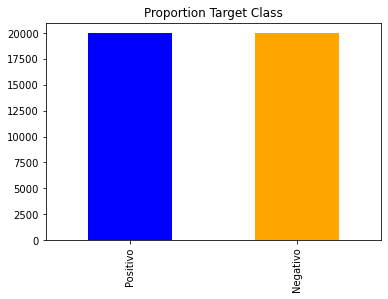

In [ ]:
count_class=pd.value_counts(tweets_df["Polaridad"], sort= True)
count_class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Proportion Target Class')
plt.show()

In [ ]:
tweets_df['Texto Preprocesado'] = tweets_df['Texto Preprocesado'].astype(str)

In [ ]:
main_text = tweets_df['Texto Preprocesado']
target = tweets_df['Polaridad']

In [ ]:
n_classes = np.unique(target)
n_classes

array(['Negativo', 'Positivo'], dtype=object)

In [ ]:
def add_label(tweet):
    output = []
    for i, s in zip(tweet.index, tweet):
        output.append(TaggedDocument(s, ["tweet_" + str(i)]))
    return output

In [ ]:
labeled_tweets = add_label(main_text)

In [ ]:
#Necesitamos vectorizar el conjunto de tweets utilizando Doc2Vec
from gensim.models import Doc2Vec

d2v_model = Doc2Vec(vector_size=100, min_count=5, epochs=10)
d2v_model.build_vocab([i for i in tqdm(labeled_tweets)])
d2v_model.train(labeled_tweets, total_examples=len(tweets_df['Texto Preprocesado']),epochs=10)
# Crea los vectores de tweets
docvec_arrays = np.zeros((len(tweets_df['Texto Preprocesado']), 100))
for i in range(len(tweets_df)):
    docvec_arrays[i,:] = d2v_model.docvecs[i].reshape((1,100))
docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape
# Etiqueta todos los tweets
labeled_reviews = add_label(tweets_df['Texto Preprocesado'])

100%|██████████| 40000/40000 [00:00<00:00, 1250090.61it/s]
C:\Users\curri\AppData\Local\Temp/ipykernel_8140/3853302831.py:10: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  docvec_arrays[i,:] = d2v_model.docvecs[i].reshape((1,100))


In [ ]:
#Definimos conjunto de entrenamiento y test
X = docvec_df #Tweet
y = target #Positivo o Negativo

X_train, X_test, y_train, y_test  = train_test_split(X,y,train_size=0.9,random_state=0)

In [ ]:
# Definir el clasificador
knn = KNeighborsClassifier()

# Definir los parámetros a explorar en GridSearch
parameters = {'n_neighbors': [3, 5, 7],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan','minkowski']}

# Definir las métricas a utilizar
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score,needs_threshold=True)
}

# Realizar GridSearch
kn_cv = GridSearchCV(knn, parameters, scoring=scoring, refit='accuracy', n_jobs=-1, cv=5, verbose=10)
kn_cv.fit(X_train, y_train)

# Predice los datos de test
y_pred = kn_cv.predict(X_test)

print('Best Accuracy Through Grid Search : {:.3f}'.format(kn_cv.best_score_))
print('Best Parameters : {}\n'.format(kn_cv.best_params_))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Accuracy Through Grid Search : 0.789
Best Parameters : {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}



In [ ]:
for accuracy, f1, roc_auc, params in zip(kn_cv.cv_results_['mean_test_accuracy'],
                             kn_cv.cv_results_['mean_test_f1'], kn_cv.cv_results_['mean_test_roc_auc'],
                             kn_cv.cv_results_['params']):
       print("%0.5f %0.5f %0.5f for %r" % (accuracy,f1,roc_auc, params))

0.76853 0.76830 0.83328 for {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.76853 0.76830 0.83555 for {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.78153 0.78132 0.85962 for {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.78153 0.78132 0.86181 for {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.78633 0.78614 0.86986 for {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
0.78633 0.78614 0.87222 for {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
0.76842 0.76818 0.83032 for {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
0.76842 0.76818 0.83208 for {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
0.78161 0.78140 0.85799 for {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
0.78161 0.78140 0.85968 for {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
0.78853 0.78831 0.86976 for {'metric': 'manhattan', 'n_neighbors': 7, 'weig

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
def ConfusionMatrix(y_pred, y_test):
     # Compute and plot the Confusion matrix
     cf_matrix = confusion_matrix(y_test, y_pred)
     categories = ['Negativo','Positivo']
     group_names = ['True Neg','False Pos', 'False Neg','True Pos']
     group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() /
    np.sum(cf_matrix)]
     labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
     labels = np.asarray(labels).reshape(2,2)
     sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
     xticklabels = categories, yticklabels = categories)
     plt.xlabel("Predicted label", fontdict = {'size':14}, labelpad = 10)
     plt.ylabel("True label" , fontdict = {'size':14}, labelpad = 10)
     plt.title ("Matriz de confusion", fontdict = {'size':18}, pad = 20)

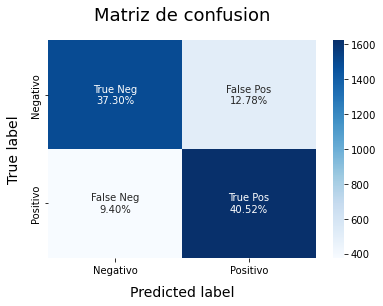

In [ ]:
ConfusionMatrix(y_pred, y_test)

In [ ]:
clf = kn_cv.best_estimator_
print('Test Accuracy (KN): %.3f' % clf.score(X_test,y_test))

Test Accuracy (KN): 0.778
